In [1]:
import os, sys
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
import IPython.display as ipd
# from asteroid.metrics import get_metrics
from pprint import pprint
import librosa

# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# torch.cuda.empty_cache()

# Get the pretrained models
print("Pre-trained models available:")
for model_name in os.listdir('../../pretrained_models'):
    print(model_name)
    
def normalize_tensor_wav(wav_tensor, eps=1e-8, std=None):
    mean = wav_tensor.mean(-1, keepdim=True)
    if std is None:
        std = wav_tensor.std(-1, keepdim=True)
    return (wav_tensor - mean) / (std + eps)
    
anechoic_model_p = '../../pretrained_models/GroupCom_Sudormrf_U8_Bases512_WSJ02mix.pt'
# anechoic_model_p = '../../pretrained_models/Improved_Sudormrf_U16_Bases512_WSJ02mix.pt'
# anechoic_model_p = '../../pretrained_models/Improved_Sudormrf_U36_Bases2048_WSJ02mix.pt'
noisy_reverberant_model_p = '../../pretrained_models/Improved_Sudormrf_U16_Bases2048_WHAMRexclmark.pt'
noisy_reverberant_model_p = '../../pretrained_models/Improved_Sudormrf_U36_Bases4096_WHAMRexclmark.pt'

# Load the appropriate class modules
sys.path.append("../../")
import sudo_rm_rf.dnn.experiments.utils.mixture_consistency as mixture_consistency
import sudo_rm_rf.dnn.models.improved_sudormrf as improved_sudormrf
import sudo_rm_rf.dnn.models.groupcomm_sudormrf_v2 as sudormrf_gc_v2

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vyd1_3l_ because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Pre-trained models available:
.DS_Store
.gitattributes
GroupCom_Sudormrf_U8_Bases512_WSJ02mix.onnx
GroupCom_Sudormrf_U8_Bases512_WSJ02mix.pt
GroupCom_Sudormrf_U8_Bases512_WSJ02mix.simplify.onnx
Improved_Sudormrf_U16_Bases2048_WHAMRexclmark.onnx
Improved_Sudormrf_U16_Bases2048_WHAMRexclmark.pt
Improved_Sudormrf_U16_Bases2048_WHAMRexclmark.simplify.onnx
Improved_Sudormrf_U16_Bases512_WSJ02mix.onnx
Improved_Sudormrf_U16_Bases512_WSJ02mix.pt
Improved_Sudormrf_U16_Bases512_WSJ02mix.simplify.onnx
Improved_Sudormrf_U36_Bases2048_WSJ02mix.pt
Improved_Sudormrf_U36_Bases4096_WHAMRexclmark.pt
download_pretrained_models.sh


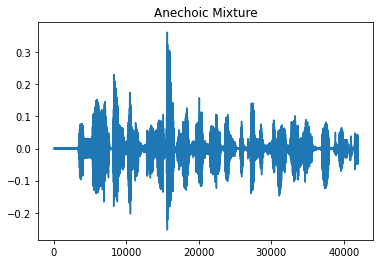

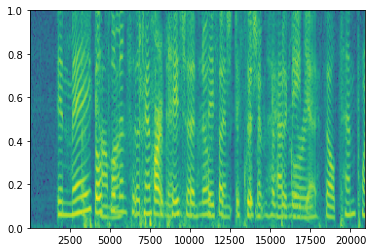

In [2]:
whamr_test_folder_path = '/mnt/data/whamr/wav8k/min/tt'
# wav_path = 'point to a random mixture file of a mixture of 2 speakers'
chosen_file = '447o030x_0.03457_441c0209_-0.03457.wav'
chosen_file = '446o030h_0.13806_444c020w_-0.13806.wav'
chosen_file = '053c0103_1.0776_441o030y_-1.0776.wav'
# chosen_file = np.random.choice(os.listdir(os.path.join(whamr_test_folder_path, 'mix_clean_anechoic')))

wav_path = os.path.join(whamr_test_folder_path, 'mix_clean_anechoic', chosen_file)

ground_truth_sources = torch.tensor(np.array([
    torchaudio.load(os.path.join(whamr_test_folder_path,
                                 's1_anechoic', chosen_file))[0].detach().numpy()[0],
    torchaudio.load(os.path.join(whamr_test_folder_path,
                                 's2_anechoic', chosen_file))[0].detach().numpy()[0]
]))

anechoic_sampled_mixture, _ = torchaudio.load(wav_path)

waveform = anechoic_sampled_mixture.detach().numpy()[0]
plt.plot(waveform)
plt.title("Anechoic Mixture")
plt.show()
plt.close()
plt.specgram(waveform)

ipd.display(ipd.Audio(waveform, rate=8000))

In [14]:
import json

def html_audio(audio: np.ndarray, sample_rate: int, element_id: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return f"""
        <script>
            if (!window.audioContext) {{
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {{
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {{
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }}
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }}
            }}
        </script>
        <button id={element_id} onclick="playAudio({json.dumps(channels)}, {sample_rate})">Play</button>
    """

### Just load a pre-trained model and apply it!

In [15]:
# Load a pretrained model
anechoic_separation_model = torch.load(anechoic_model_p)

y, sr = torchaudio.load("../../../samples/blindset/noisy/noreverb_fileid_54.wav")
print(y.shape, sr)

transformed = torchaudio.transforms.Resample(sr, 8000)(y)
print(transformed.shape)

# y, sr = librosa.load("../../../samples/blindset/noisy/noreverb_fileid_54.wav", sr=8000)
# print(y.shape, sr)

# Normalize the waveform and apply the model
input_mix_std = transformed.std(-1, keepdim=True)
input_mix_mean = transformed.mean(-1, keepdim=True)
input_mix = (transformed - input_mix_mean) / (input_mix_std + 1e-9)

# # Apply the model
with torch.no_grad():
    print('input_mix', input_mix.shape)
    rec_sources_wavs = anechoic_separation_model(input_mix.unsqueeze(1))

print(rec_sources_wavs.shape)
# # In case you are using the pre-trained models with Group communication
# # please also use the mixture consistency right after the estimated waveforms
if "GroupCom" in anechoic_model_p:
    rec_sources_wavs = mixture_consistency.apply(rec_sources_wavs, input_mix.unsqueeze(1))

# Rescale the input sources with the mixture mean and variance
rec_sources_wavs = (rec_sources_wavs * input_mix_std) + input_mix_mean
# It is that simple!

waveform = rec_sources_wavs.detach().numpy()[0][0]
print('waveform', waveform.shape)

ipd.display(ipd.HTML(html_audio(waveform, 8000, 1)))

# torchaudio.save('../../../samples/1.wav', waveform[np.newaxis, ...], 8000)

# plt.plot(waveform)
# plt.title("Anechoic Mixture")
# plt.show()
# plt.close()
# plt.specgram(waveform[0])

# ipd.display(ipd.Audio(waveform, rate=8000))

# librosa.write_wav("newFilename.wav", y_8k, 8000)

torch.Size([1, 160000]) 16000
torch.Size([1, 80000])
input_mix torch.Size([1, 80000])
torch.Size([1, 2, 80000])
waveform (80000,)


In [10]:
# We can also find the appropriate order of the sources
import asteroid
pairwise_negsisdr_func = asteroid.losses.PairwiseNegSDR("sisdr")
sisdrs = -pairwise_negsisdr_func(rec_sources_wavs, ground_truth_sources.unsqueeze(0))
if sisdrs[0, 0, 0] + sisdrs[0, 1, 1] < sisdrs[0, 1, 0] + sisdrs[0, 0, 1]:
    rec_sources_wavs = torch.flip(rec_sources_wavs, [1])
    print("Changed the order of sources for best allignment")

ModuleNotFoundError: No module named 'asteroid'

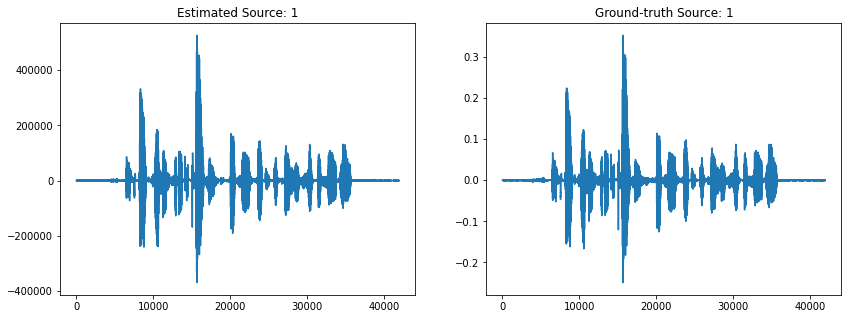

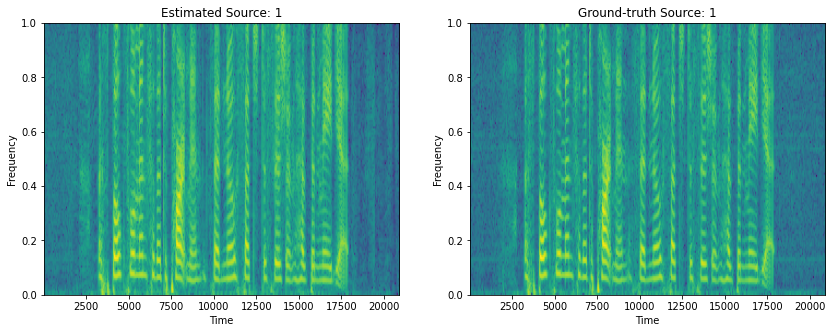

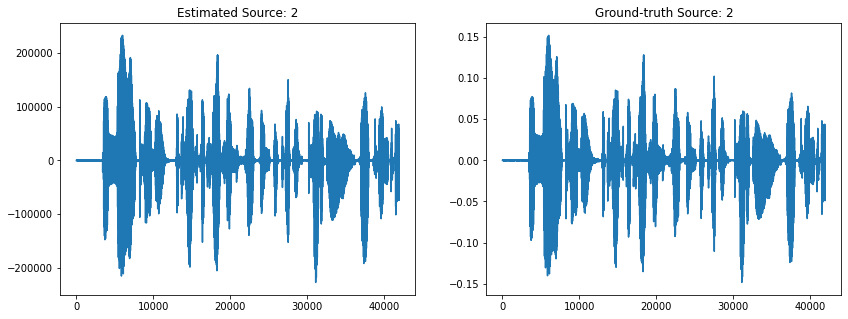

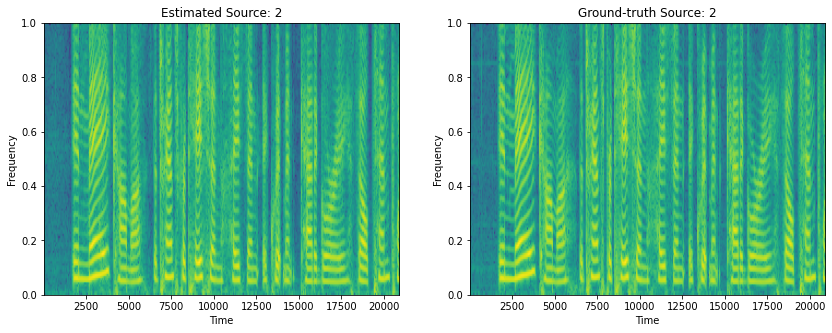

{'input_pesq': 1.564863920211792,
 'input_sar': 120.70143544498148,
 'input_sdr': 0.12323777756610788,
 'input_si_sdr': 0.017620205879211426,
 'input_sir': 0.12323777757361987,
 'input_stoi': 0.7540033083315296,
 'pesq': 3.748028039932251,
 'sar': 21.378711367213462,
 'sdr': 21.056346044719184,
 'si_sdr': 20.80234718322754,
 'sir': 32.79707712846574,
 'stoi': 0.9881496110461456}


In [5]:
# Plot the separated waveforms and their corresponding metrics 
for src_idx in range(rec_sources_wavs.shape[1]):
    est_waveform = rec_sources_wavs[0, src_idx].detach().numpy()
    gt_waveform = ground_truth_sources[src_idx].detach().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].plot(est_waveform)
    ax[1].plot(gt_waveform)
    ax[0].set_title(f"Estimated Source: {src_idx + 1}")
    ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
    plt.show()
    plt.close()
    
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].specgram(est_waveform)
    ax[1].specgram(gt_waveform)
    ax[0].set_title(f"Estimated Source: {src_idx + 1}")
    ax[0].set_ylabel(f"Frequency")
    ax[0].set_xlabel(f"Time")
    ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
    ax[1].set_ylabel(f"Frequency")
    ax[1].set_xlabel(f"Time")
    plt.show()
    plt.close()
    
    ipd.display(ipd.Audio(est_waveform, rate=8000))
    ipd.display(ipd.Audio(gt_waveform, rate=8000))

metrics_dict = get_metrics(input_mix[0].detach().numpy(),
                           normalize_tensor_wav(ground_truth_sources).detach().numpy(),
                           normalize_tensor_wav(rec_sources_wavs[0]).detach().numpy(),
                           compute_permutation=True, sample_rate=8000, metrics_list='all')
pprint(metrics_dict)

## Wait... that means that we can Sudo rm -rf also reverberant and noisy sources?

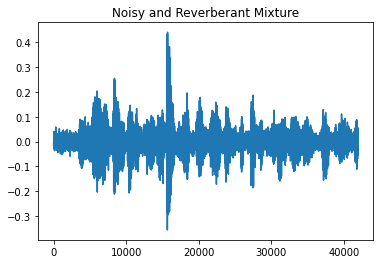

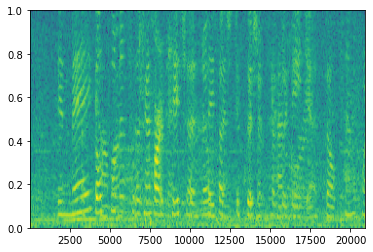

In [6]:
wav_path = os.path.join(whamr_test_folder_path, 'mix_both_reverb', chosen_file)
noisy_reverberant_sampled_mixture, _ = torchaudio.load(wav_path)

waveform = noisy_reverberant_sampled_mixture.detach().numpy()[0]
plt.plot(waveform)
plt.title("Noisy and Reverberant Mixture")
plt.show()
plt.close()
plt.specgram(waveform)


ipd.display(ipd.Audio(waveform, rate=8000))


### Of course we can Sudo rm-rf anything!

In [7]:
noisy_and_reverberant_separation_model = torch.load(noisy_reverberant_model_p)

# Normalize the waveform and apply the model
input_mix_std = noisy_reverberant_sampled_mixture.std(-1, keepdim=True)
input_mix_mean = noisy_reverberant_sampled_mixture.mean(-1, keepdim=True)
input_mix = (noisy_reverberant_sampled_mixture - input_mix_mean) / (input_mix_std + 1e-9)

# Apply the model
with torch.no_grad():
    rec_sources_wavs = noisy_and_reverberant_separation_model(input_mix.unsqueeze(1))

# # In case you are using the pre-trained models with Group communication
# # please also use the mixture consistency right after the estimated waveforms
# import sudo_rm_rf.dnn.experiments.utils.mixture_consistency as mixture_consistency
# rec_sources_wavs = mixture_consistency.apply(rec_sources_wavs, input_mix.unsqueeze(1))

# Rescale the input sources with the mixture mean and variance
rec_sources_wavs = (rec_sources_wavs * input_mix_std) + input_mix_mean

In [8]:
# We can also find the appropriate order of the sources
import asteroid
pairwise_negsisdr_func = asteroid.losses.PairwiseNegSDR("sisdr")
sisdrs = -pairwise_negsisdr_func(rec_sources_wavs, ground_truth_sources.unsqueeze(0))
if sisdrs[0, 0, 0] + sisdrs[0, 1, 1] < sisdrs[0, 1, 0] + sisdrs[0, 0, 1]:
    rec_sources_wavs = torch.flip(rec_sources_wavs, [1])
    print("Changed the order of sources for best allignment")

Changed the order of sources for best allignment


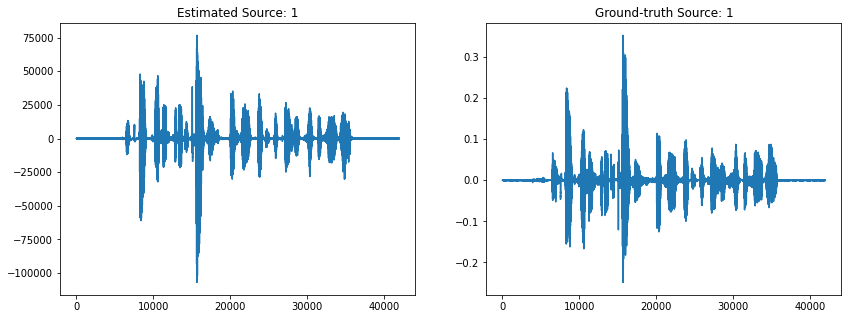

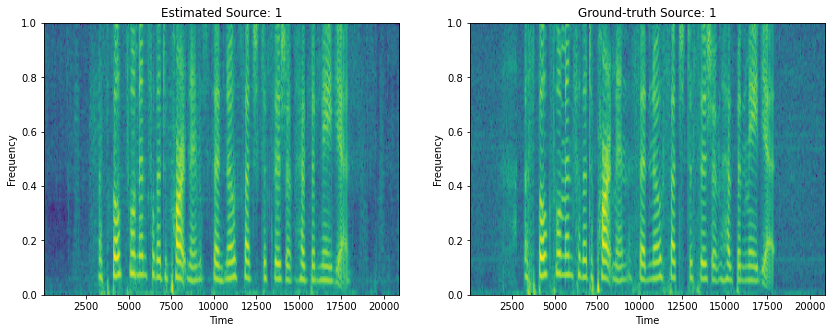

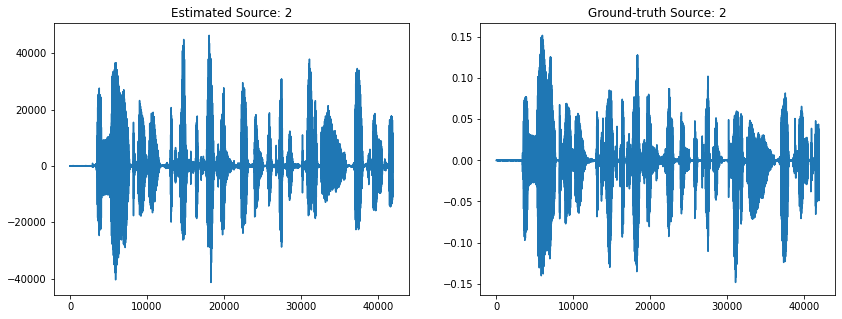

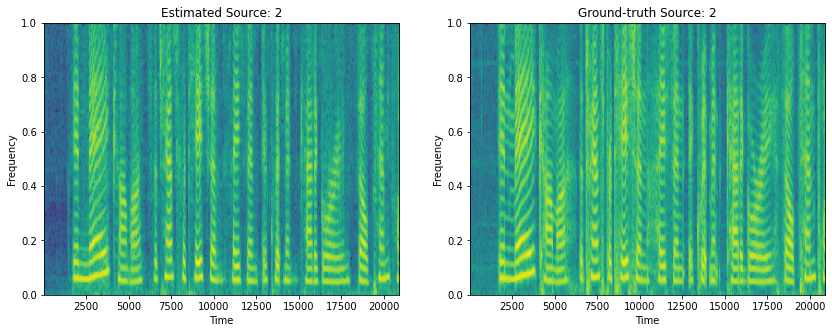

{'input_pesq': 1.3632924556732178,
 'input_sar': 6.252398689926332,
 'input_sdr': -1.6131780605167125,
 'input_si_sdr': -3.255383610725403,
 'input_sir': 0.10308398084090636,
 'input_stoi': 0.6520305655035785,
 'pesq': 2.381341576576233,
 'sar': 11.327975622960544,
 'sdr': 11.150320575633337,
 'si_sdr': 8.828220844268799,
 'sir': 25.449670536122557,
 'stoi': 0.907110897672928}


In [9]:
# Plot the separated waveforms and their corresponding metrics 
for src_idx in range(rec_sources_wavs.shape[1]):
    est_waveform = rec_sources_wavs[0, src_idx].detach().numpy()
    gt_waveform = ground_truth_sources[src_idx].detach().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].plot(est_waveform)
    ax[1].plot(gt_waveform)
    ax[0].set_title(f"Estimated Source: {src_idx + 1}")
    ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
    plt.show()
    plt.close()
    
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].specgram(est_waveform)
    ax[1].specgram(gt_waveform)
    ax[0].set_title(f"Estimated Source: {src_idx + 1}")
    ax[0].set_ylabel(f"Frequency")
    ax[0].set_xlabel(f"Time")
    ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
    ax[1].set_ylabel(f"Frequency")
    ax[1].set_xlabel(f"Time")
    plt.show()
    plt.close()
    
    ipd.display(ipd.Audio(est_waveform, rate=8000))
    ipd.display(ipd.Audio(gt_waveform, rate=8000))

metrics_dict = get_metrics(input_mix[0].detach().numpy(),
                           normalize_tensor_wav(ground_truth_sources).detach().numpy(),
                           normalize_tensor_wav(rec_sources_wavs[0]).detach().numpy(),
                           compute_permutation=True, sample_rate=8000, metrics_list='all')
pprint(metrics_dict)

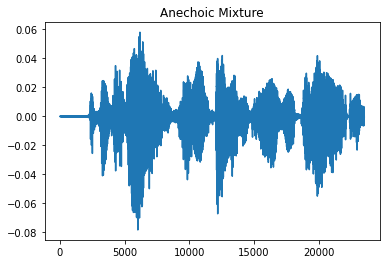

GroupCom_Sudormrf_U8_Bases512_WSJ02mix.pt


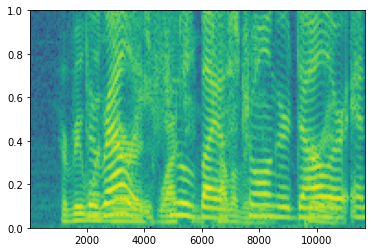

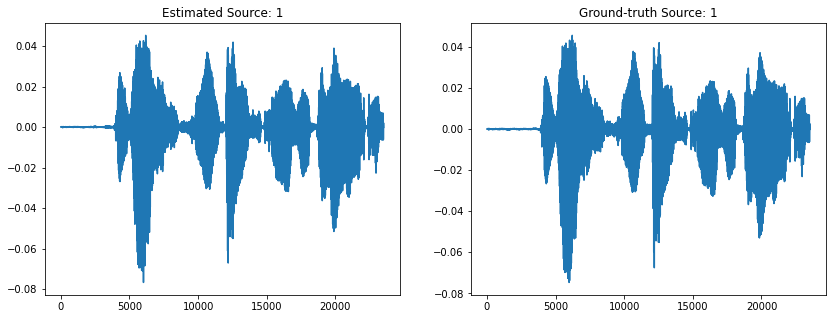

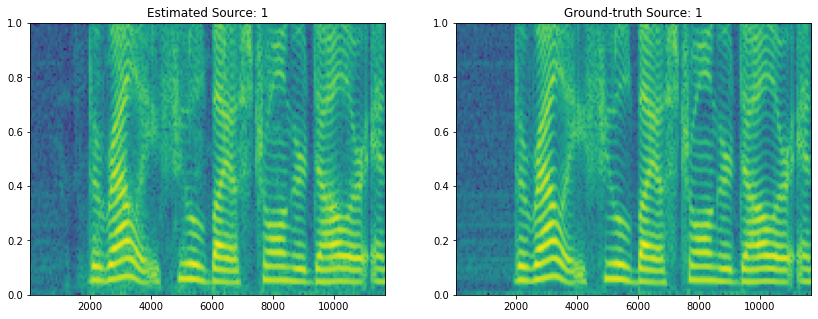

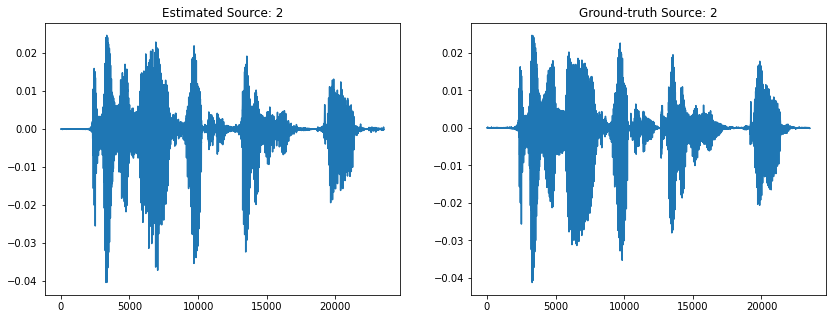

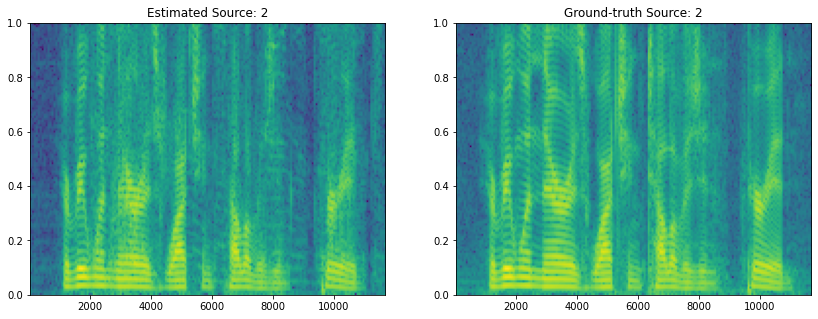

{'input_pesq': 1.5536472797393799,
 'input_sar': 111.50071007120339,
 'input_sdr': 0.19034823504864118,
 'input_si_sdr': -0.1123659610748291,
 'input_sir': 0.1903482351551249,
 'input_stoi': 0.7038161651466409,
 'pesq': 2.975192427635193,
 'sar': 16.24307476455582,
 'sdr': 15.412638084495393,
 'si_sdr': 14.819087982177734,
 'sir': 23.142914937223672,
 'stoi': 0.9467367012640417}
Improved_Sudormrf_U16_Bases512_WSJ02mix.pt


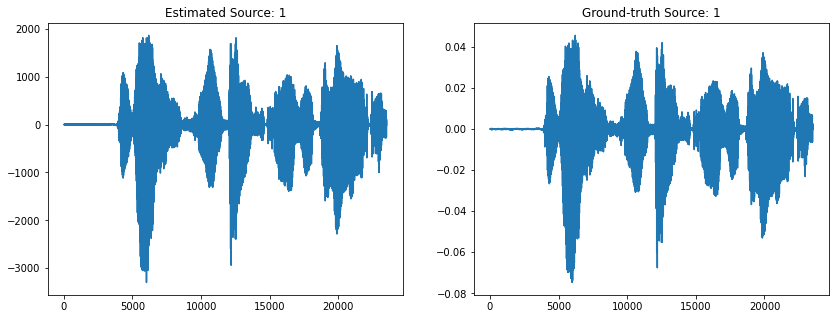

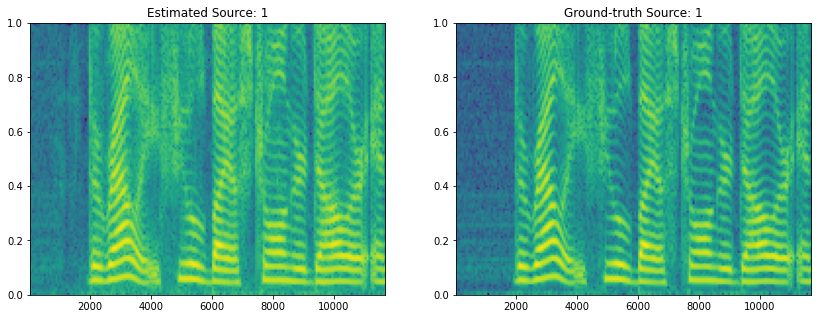

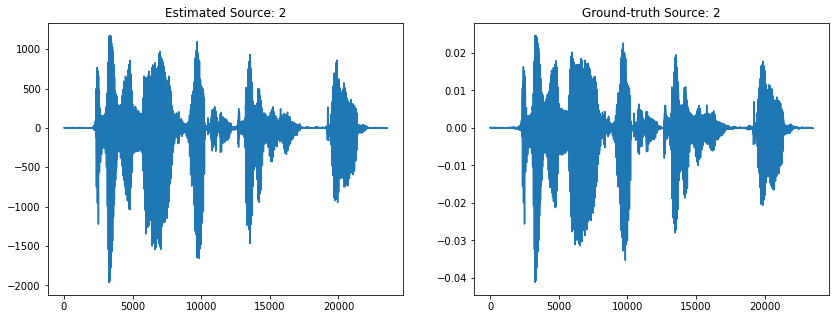

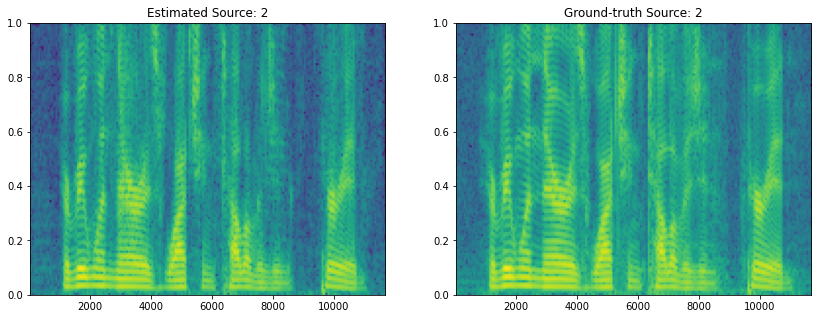

{'input_pesq': 1.5536472797393799,
 'input_sar': 111.50071007120339,
 'input_sdr': 0.19034823504864118,
 'input_si_sdr': -0.1123659610748291,
 'input_sir': 0.1903482351551249,
 'input_stoi': 0.7038161651466409,
 'pesq': 3.4838085174560547,
 'sar': 20.09172172281448,
 'sdr': 19.346265438526864,
 'si_sdr': 18.647472858428955,
 'sir': 27.451144382362294,
 'stoi': 0.9711489199320683}
Improved_Sudormrf_U36_Bases2048_WSJ02mix.pt
Changed the order of sources for best allignment


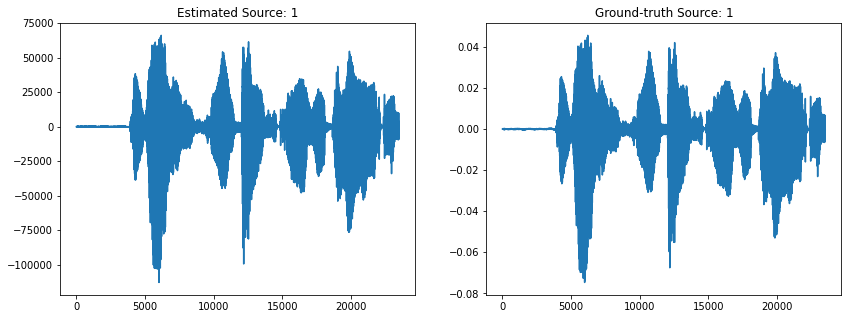

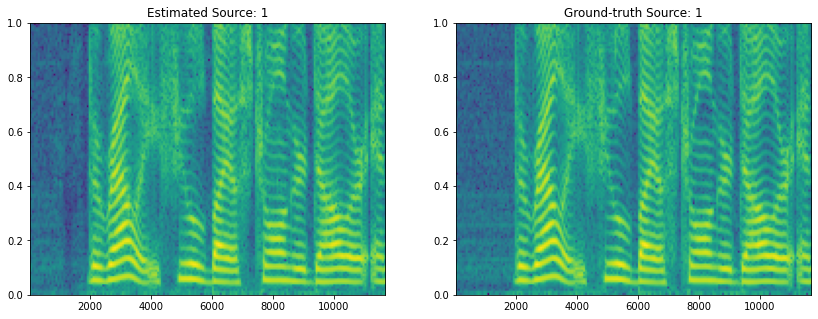

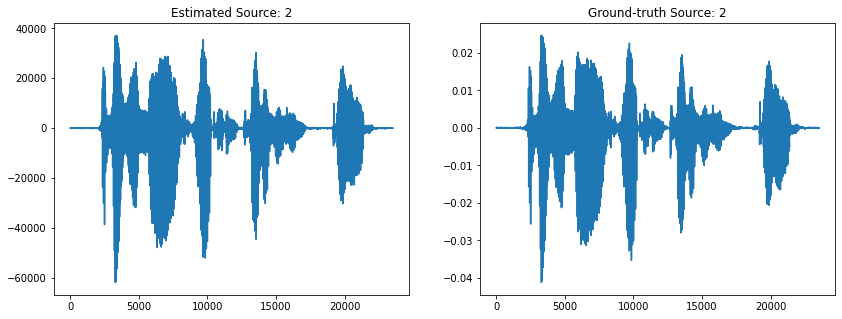

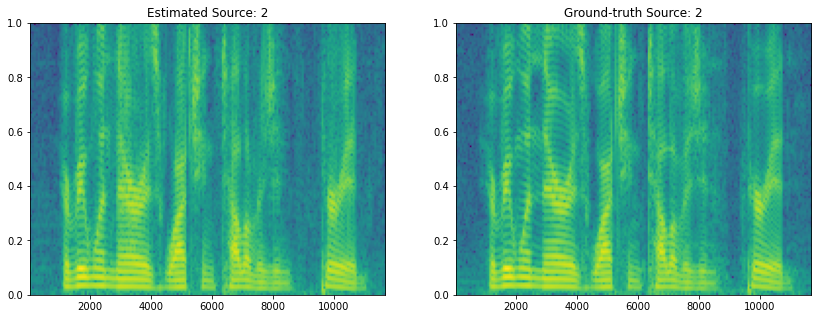

{'input_pesq': 1.5536472797393799,
 'input_sar': 111.50071007120339,
 'input_sdr': 0.19034823504864118,
 'input_si_sdr': -0.1123659610748291,
 'input_sir': 0.1903482351551249,
 'input_stoi': 0.7038161651466409,
 'pesq': 3.7625033855438232,
 'sar': 21.85223830051232,
 'sdr': 21.097255092720026,
 'si_sdr': 20.39334774017334,
 'sir': 29.13164203252428,
 'stoi': 0.9820524082909059}


In [10]:
# Just to understand the difference, play the output of a few different models
all_anechoic_models_paths = [
    '../../pretrained_models/GroupCom_Sudormrf_U8_Bases512_WSJ02mix.pt',
    '../../pretrained_models/Improved_Sudormrf_U16_Bases512_WSJ02mix.pt',
    '../../pretrained_models/Improved_Sudormrf_U36_Bases2048_WSJ02mix.pt']


chosen_file = '447o030x_0.03457_441c0209_-0.03457.wav'
chosen_file = '446o030h_0.13806_444c020w_-0.13806.wav'
chosen_file = '052a0507_1.6424_422a0109_-1.6424.wav'
chosen_file = np.random.choice(os.listdir(os.path.join(whamr_test_folder_path, 'mix_clean_anechoic')))
chosen_file = '421c020g_2.223_22go0102_-2.223.wav'

wav_path = os.path.join(whamr_test_folder_path, 'mix_clean_anechoic', chosen_file)

ground_truth_sources = torch.tensor(np.array([
    torchaudio.load(os.path.join(whamr_test_folder_path,
                                 's1_anechoic', chosen_file))[0].detach().numpy()[0],
    torchaudio.load(os.path.join(whamr_test_folder_path,
                                 's2_anechoic', chosen_file))[0].detach().numpy()[0]
]))

anechoic_sampled_mixture, _ = torchaudio.load(wav_path)

waveform = anechoic_sampled_mixture.detach().numpy()[0]
plt.plot(waveform)
plt.title("Anechoic Mixture")
plt.show()
plt.close()
plt.specgram(waveform)

ipd.display(ipd.Audio(waveform, rate=8000))

for anechoic_model_p in all_anechoic_models_paths:
    model_name = os.path.basename(anechoic_model_p)
    print(model_name)
    
    # Load a pretrained model
    anechoic_separation_model = torch.load(anechoic_model_p)

    # Normalize the waveform and apply the model
    input_mix_std = anechoic_sampled_mixture.std(-1, keepdim=True)
    input_mix_mean = anechoic_sampled_mixture.mean(-1, keepdim=True)
    input_mix = (anechoic_sampled_mixture - input_mix_mean) / (input_mix_std + 1e-9)

    # Apply the model
    with torch.no_grad():
        rec_sources_wavs = anechoic_separation_model(input_mix.unsqueeze(1))

        # # In case you are using the pre-trained models with Group communication
        # # please also use the mixture consistency right after the estimated waveforms
        if "GroupCom" in model_name:
            rec_sources_wavs = mixture_consistency.apply(rec_sources_wavs, input_mix.unsqueeze(1))

        # Rescale the input sources with the mixture mean and variance
        rec_sources_wavs = (rec_sources_wavs * input_mix_std) + input_mix_mean
    
    pairwise_negsisdr_func = asteroid.losses.PairwiseNegSDR("sisdr")
    sisdrs = -pairwise_negsisdr_func(rec_sources_wavs, ground_truth_sources.unsqueeze(0))
    if sisdrs[0, 0, 0] + sisdrs[0, 1, 1] < sisdrs[0, 1, 0] + sisdrs[0, 0, 1]:
        rec_sources_wavs = torch.flip(rec_sources_wavs, [1])
        print("Changed the order of sources for best allignment")
    
    
    for src_idx in range(rec_sources_wavs.shape[1]):
        est_waveform = rec_sources_wavs[0, src_idx].detach().numpy()
        gt_waveform = ground_truth_sources[src_idx].detach().numpy()
        fig, ax = plt.subplots(1, 2, figsize=(14,5))
        ax[0].plot(est_waveform)
        ax[1].plot(gt_waveform)
        ax[0].set_title(f"Estimated Source: {src_idx + 1}")
        ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
        plt.show()
        plt.close()

        fig, ax = plt.subplots(1, 2, figsize=(14,5))
        ax[0].specgram(est_waveform)
        ax[1].specgram(gt_waveform)
        ax[0].set_title(f"Estimated Source: {src_idx + 1}")
        ax[1].set_title(f"Ground-truth Source: {src_idx + 1}")
        plt.show()
        plt.close()

        ipd.display(ipd.Audio(est_waveform, rate=8000))
        ipd.display(ipd.Audio(gt_waveform, rate=8000))

    metrics_dict = get_metrics(input_mix[0].detach().numpy(),
                               normalize_tensor_wav(ground_truth_sources).detach().numpy(),
                               normalize_tensor_wav(rec_sources_wavs[0]).detach().numpy(),
                               compute_permutation=True, sample_rate=8000, metrics_list='all')
    pprint(metrics_dict)
    

In [2]:
import torch
torch.__version__

'1.8.2+cpu'